<a href="https://colab.research.google.com/github/adikusuma14/medical_cost/blob/main/medical_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

Insurance companies in the United States want to predict the range of personal medical costs who receive benefits

# Data Understanding




This dataset has the following columns:
* age: age of primary beneficiary
* sex: insurance contractor gender, female, male
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical costs billed by health insurance
<br>https://www.kaggle.com/datasets/mirichoi0218/insurance





# Data Preparation

Some libraries have not been installed in Google Collaboratory, so you can install them manually

In [1]:
#install library not available in google colab
!pip install dataprep
!pip install scikit-learn==0.24
!pip install pycaret
!pip install numpy==1.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 7.5 MB/s 
     |████████████████████████████████| 1.1 MB 31.0 MB/s 
     |████████████████████████████████| 1.0 MB 54.9 MB/s 
     |████████████████████████████████| 133 kB 33.7 MB/s 
     |████████████████████████████████| 33.8 MB 161 kB/s 
     |████████████████████████████████| 2.2 MB 49.9 MB/s 
     |████████████████████████████████| 764 kB 46.8 MB/s 
     |████████████████████████████████| 1.0 MB 8.9 MB/s 
     |████████████████████████████████| 1.3 MB 38.3 MB/s 
     |████████████████████████████████| 101 kB 11.4 MB/s 
     |████████████████████████████████| 96 kB 5.7 MB/s 
     |████████████████████████████████| 232 kB 12.2 MB/s 
     |████████████████████████████████| 1.6 MB 33.7 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 133 kB 40.2 MB/s 
  Created wheel for metaphone: filena

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.4 MB 8.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.20.0 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.20.0 which is incompatible.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 2.3.8 which is incompatible.
dataprep 0.4.5 requires numpy<2.0,>=1.21, but you have numpy 1.20.0 which is incompatible.
dataprep 0.4.5 requires scipy<2.0,>=1.8, but you have scipy 1.5.4 which is incompatible.
dataprep 0.4.5 requires sqlalchemy==1.3.24, 

Import library necesarry for build data pipeline

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataprep.eda import create_report
from dataprep.clean import clean_duplication
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import make_pipeline, Pipeline

Mounted at /content/drive


In [3]:
#declare path dataset
path = '/content/drive/MyDrive/datasets/medical_cost/insurance.csv'

#read dataset
df = pd.read_csv(path)

#sampling dataset with 10 rows of data
df.sample(10)

,age,sex,bmi,children,smoker,region,charges
517,45,male,30.495,2,no,northwest,8413.46305
939,53,male,29.480,0,no,southeast,9487.64420
570,31,female,29.100,0,no,southwest,3761.29200
421,61,male,35.860,0,yes,southeast,46599.10840
308,58,male,34.865,0,no,northeast,11944.59435
860,37,female,47.600,2,yes,southwest,46113.51100
948,42,male,31.255,0,no,northwest,6358.77645
212,24,male,28.500,2,no,northwest,3537.70300
895,61,female,44.000,0,no,southwest,13063.88300
784,31,female,29.260,1,no,southeast,4350.51440


DataPrep Report
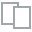
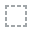
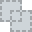
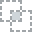
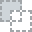
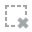
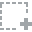
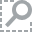
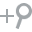
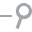
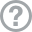
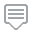
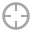
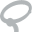
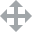
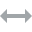
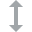
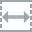
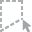
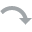
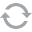
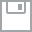
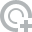
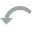
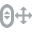
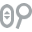
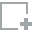
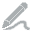
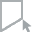
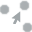
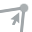
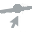

In [4]:
#Exploratory Data Analysis with create_report() from dataprep
def reporting(dataframe):
  report = create_report(dataframe)
  return report

reporting(df)

In the first data exploration we get some information, namely:
1. 7 features in the dataset
2. The amount of data is 1338 rows of data
3. the number of duplicate data is 1 row of data
4. 3 numeric data types and 4 categorical data types
5. the smoker feature contains imbalanced data
6. target feature highly right skew

The next step is
1. Check for outliers in every numeric feature
2. Remove duplicate data if there are not too many in the dataset
3. Delete the multicorrelation feature above > 0.7 if any
4. Balance categorical features if imbalance
5. Transform the distribution of highly skewed numerical features to approximate the normal

In [5]:
#Check rows with duplicate values
def check_duplicates_rows(dataframe):
  print(dataframe.loc[dataframe.duplicated(keep=False), :])

check_duplicates_rows(df)

#function for check features with null value
def check_null(dataframe):
  print(dataframe.shape[0], 'Rows', dataframe.shape[1], 'Columns')
  missing_column = (dataframe.isnull().sum())
  print(missing_column[missing_column > 0])

check_null(df)

#split numeric and categorical feature
def split_features(dataframe):
  num = [num for num in dataframe.columns if dataframe[num].dtype in ['int64', 'float64']]
  cat = [cat for cat in dataframe.columns if dataframe[cat].dtypes == 'object']
  return num, cat

num = split_features(df)[0]
cat = split_features(df)[1]

#function for print number unique categorical features and sorted ascending
def n_unique_categorical(dataframe):
  cat_unique = list(map(lambda col: dataframe[col].nunique(), cat))
  d = dict(zip(cat, cat_unique))
  return sorted(d.items(), key=lambda x: x[1])

n_unique_categorical(df)


     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631
1338 Rows 7 Columns
Series([], dtype: int64)


[('sex', 2), ('smoker', 2), ('region', 4)]

In [6]:
#drop rows with duplicate values
def drop_duplicate_rows(dataframe):
  df_drop = df.drop_duplicates(keep='first')
  return df_drop

df_drop = drop_duplicate_rows(df)

In [7]:
#Check duplicate rows after drop duplicate
print(check_duplicates_rows(df_drop))

Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
None


In [8]:
def check_balance_data(dataframe, cat):
  print('Proportion of the classes in the data:')
  print(dataframe[cat].value_counts() / dataframe.shape[0])

In [9]:
#funtion check outlier numeric features using boxplot
def boxplot(feature):
  features = feature
  plt.figure(figsize=(20, 4))
  for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='green')
    plt.tight_layout

#function check distribution categorical features using countplot
def countplot(feature):
  features = feature
  plt.figure(figsize=(20, 4))
  for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.countplot(df[features[i]], color='green')
    plt.tight_layout()

DataPrep Report
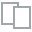
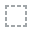
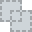
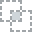
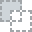
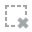
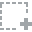
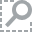
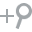
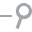
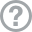
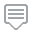
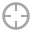
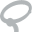
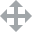
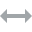
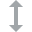
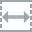
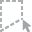
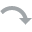
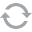
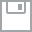
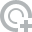
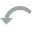
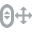
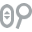
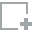
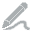
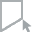
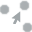
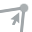
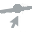

In [10]:
#report after drop duplicate
report_after_duplicate = reporting(df_drop)
report_after_duplicate

In [11]:
check_balance_data(df_drop, 'smoker')

Proportion of the classes in the data:
no     0.795064
yes    0.204936
Name: smoker, dtype: float64


# Modeling

In [12]:
#split dataset to training and validation
X = df_drop.drop(labels='charges', axis=1)
y = df_drop['charges']
X_train_full, X_val_full, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#split categorical and numeric from numeric
num_full = split_features(X_train_full)[0]
cat_full = split_features(X_train_full)[1]

#keep selected column selected column
my_cols = cat_full + num_full
X_train = X_train_full[my_cols].copy()
X_val = X_val_full[my_cols].copy()

#use regressor model
lin = LinearRegression()
ridge = Ridge()
dtr = DecisionTreeRegressor()
rf = RandomForestRegressor()

#preprocessing for numerical features
numerical_transformer = SimpleImputer(strategy='constant')

#preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#bundle numeric and categorical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, num_full),
    ('cat', categorical_transformer, cat_full)
])

#create regressors list
regressors = [lin, ridge, dtr, rf]

#loop list of regressors for fit training and predict
def evaluation(regressors, X_train, X_val, y_train, y_val):
  for regressor in regressors:
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('regressor', regressor)
      ])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, pred)
    mse = mean_squared_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    print(f'{regressor}, MAE: {mae}, MSE: {mse}, R2: {r2}')

evaluation(regressors, X_train, X_val, y_train, y_val)

LinearRegression(), MAE: 4177.045561036319, MSE: 35478020.67523556, R2: 0.8069287081198014
Ridge(), MAE: 4185.524666874397, MSE: 35566368.05120599, R2: 0.8064479219404095
DecisionTreeRegressor(), MAE: 2749.1684918619403, MSE: 37750924.91714643, R2: 0.7945595694262206
RandomForestRegressor(), MAE: 2591.4623938701498, MSE: 21508251.657374445, R2: 0.8829521530643808


# Evaluation